# 13.9 语义分割和数据集
- **目录**
  - 13.9.1 图像分割和实例分割
  - 13.9.2 Pascal VOC2012 语义分割数据集
    - 13.9.2.1 预处理数据
    - 13.9.2.2 自定义语义分割数据集类
    - 13.9.2.3 读取数据集
    - 13.9.2.4 整合所有组件


- 在 13.3节—13.8节中讨论的目标检测问题中，我们一直使用**方形边界框来标注和预测图像中的目标**。
- 本节将探讨**语义分割（semantic segmentation）** 问题，它重点关注于如何将图像分割成属于不同语义类别的区域。
- 与目标检测不同，语义分割可以识别并理解图像中**每一个像素**的内容：其语义区域的标注和预测是**像素级**的。
- 图13.9.1展示了语义分割中图像有关狗、猫和背景的标签。
- 与目标检测相比，语义分割标注的像素级的边框显然**更加精细**。
<center><img src='../img/segmentation.svg'></center>
<center>图13.9.1 语义分割中图像有关狗、猫和背景的标签</center>

## 13.9.1 图像分割和实例分割

- 计算机视觉领域还有2个与语义分割相似的重要问题，即**图像分割（image segmentation）**和**实例分割（instance segmentation）**。
- 我们在这里将它们同语义分割简单区分一下。
  * **图像分割**将图像划分为若干组成区域，这类问题的方法通常利用图像中像素之间的相关性。它在训练时**不需要有关图像像素的标签信息**，在预测时也无法保证分割出的区域具有我们希望得到的语义。以图13.9.1中的图像作为输入，图像分割可能会将狗分为两个区域：一个覆盖以黑色为主的嘴和眼睛，另一个覆盖以黄色为主的其余部分身体。
  * **实例分割**也叫**同时检测并分割（simultaneous detection and segmentation）**，它研究如何识别图像中各个目标实例的像素级区域。与语义分割不同，实例分割**不仅需要区分语义，还要区分不同的目标实例**。例如，如果图像中有两条狗，则实例分割需要区分像素属于的两条狗中的哪一条。

## 13.9.2 Pascal VOC2012 语义分割数据集

- 最重要的语义分割数据集之一是[Pascal VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)。

- VOC2012数据集包含以下内容：
  - **类别数量**：20个目标类别。
  - **标注类型**：每张图像都带有丰富的标注信息，包括**目标边界框**、**类别标签**、**像素级分割掩码**等。
- **类别列表**：VOC2012数据集包含20个常见的目标类别，分为以下四类：
  - **(1)交通工具**：
    - 飞机（aeroplane）
    - 自行车（bicycle）
    - 船（boat）
    - 公交车（bus）
    - 汽车（car）
    - 摩托车（motorbike）
    - 火车（train）
  - **(2)家具/室内物品**：
    - 瓶子（bottle）
    - 椅子（chair）
    - 餐桌（dining table）
    - 盆栽（potted plant）
    - 沙发（sofa）
    - 显示器（tv/monitor）
  - **(3)动物**：
    - 鸟（bird）
    - 猫（cat）
    - 牛（cow）
    - 狗（dog）
    - 马（horse）
    - 羊（sheep）
  - **(4)人**：
     - 人（person）

- **数据集结构**

```
VOC2012/
├── Annotations/          # 标注文件（XML格式，包含目标边界框和类别信息）
├── ImageSets/            # 图像集划分文件（训练集、验证集等）
│   ├── Main/             # 每个类别的训练/验证集划分
│   ├── Layout/           # 包含人体部位标注的图像划分
│   ├── Segmentation/     # 用于语义分割任务的图像划分
├── JPEGImages/           # 图像文件（JPEG格式）
├── SegmentationClass/    # 语义分割的类别标注（PNG格式）
├── SegmentationObject/    # 实例分割的标注（PNG格式）

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

- VOC数据集压缩文件有1.86G，点击[下载](http://d2l-data.s3-accelerate.amazonaws.com/VOCtrainval_11-May-2012.tar)。
- 提取出的数据集位于`../data/VOCdevkit/VOC2012`。


In [2]:
#@save
## 建议手工下载，然后保存在../data目录,解压到当前文件夹即可
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

- 进入路径`../data/VOCdevkit/VOC2012`之后，我们可以看到数据集的不同组件。
- **`ImageSets/Segmentation`路径包含用于训练和测试样本的文本文件，而`JPEGImages`和`SegmentationClass`路径分别存储着每个示例的输入图像和标签**。
- 此处的标签也采用图像格式，其尺寸和它所标注的输入图像的尺寸相同。
- 此外，标签中颜色相同的像素属于**同一个语义类别**。
- 下面将`read_voc_images`函数定义为**将所有输入的图像和标签读入内存**。


In [ ]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels
voc_dir ='../data/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(voc_dir, True)

- read_voc_images详细注释版

In [2]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    # 训练图像的文件名列表存放在../data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split() #从train.txt读出所有训练图像的文件名，不包含扩展名
    features, labels = [], []
    for i, fname in enumerate(images):
        '''
        将训练图像及其标签分别读到features和labels列表。
        torchvision.io.read_image读取图像后保存格式为Pytorch的Tensor，
        其形状为(C,H,W)即通道维在第1维，所以后面显示图像时，需将通道维重排到第3维。
        '''
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        '''
        注意读取png格式图像文件，需要设定mode参数为RGB。
        png图像有多种模式，包括：灰度、RGB、RGBA，此处设定为RGB，与特征数据保持一致。
        '''
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode)) 
    return features, labels

# 手工下载后解压后的数据集所文件夹路径
voc_dir ='../data/VOCdevkit/VOC2012'
# 此处只加载训练数据集
train_features, train_labels = read_voc_images(voc_dir, True)

- 下面绘制前5个输入图像及其标签。
- 在标签图像中，白色和黑色分别表示边框和背景，而其他颜色则对应不同的类别。


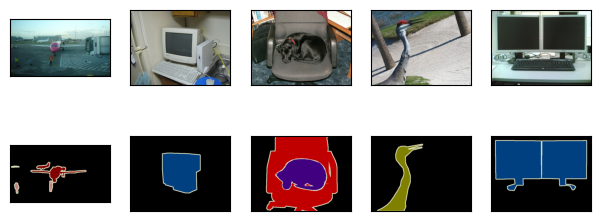

In [3]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

- 接下来，我们列举**RGB颜色值**和**类名**。


In [8]:
#@save
# 语义分割的目标掩码
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
## VOC数据集的类型有20个，加上背景类别为21个
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

- 通过上面定义的两个常量，可以方便地**查找标签中每个像素的类索引**。
- 我们定义了`voc_colormap2label`函数来构建从上述RGB颜色值到类别索引的映射，而`voc_label_indices`函数将RGB值映射到在Pascal VOC2012数据集中的类别索引。


In [5]:
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

- voc_colormap2label与voc_label_indices详细注释

In [9]:
#@save
def voc_colormap2label():
    '''
    构建从RGB到VOC类别索引的映射。
    详细计算过程和机制可参考本节末尾的说明。
    colormap2label是一个十分稀疏的向量，共有256**3元素，
    其中在本例中只使用了21个元素保存类别索引。    
    '''
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    '''
    将VOC标签中的RGB值映射到它们的类别索引。
        
    '''
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [27]:
# 2的24次方, [192, 128, 0]的索引为12615680
colormap2label = voc_colormap2label()
colormap2label.shape, 2**24, (192*256+128)*256+0*256,colormap2label[12615680]

(torch.Size([16777216]), 16777216, 12615680, tensor(11))

------
- **说明：voc_colormap2label与voc_label_indices函数功能**
  - 将label中的目标像素标签RGB值映射为类别的索引。 

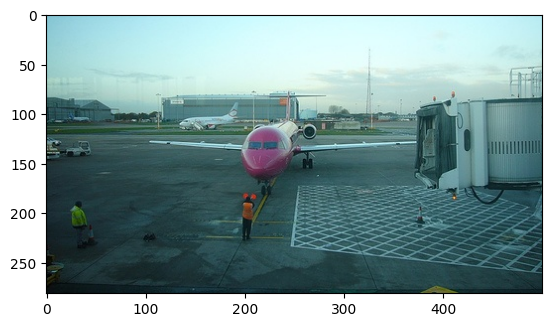

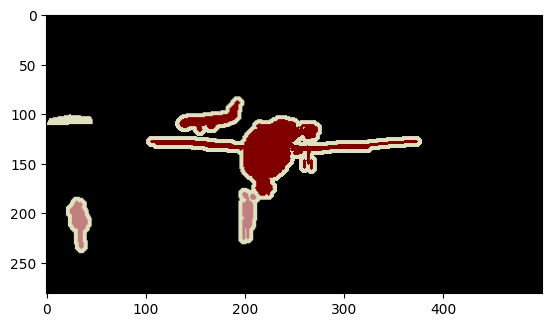

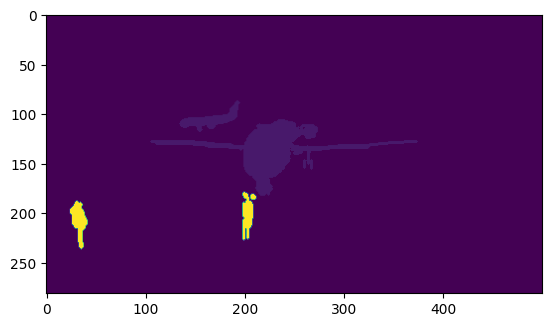

In [14]:
# 可视化类别索引
import numpy as np
import matplotlib.pyplot as plt
# 取出标签掩码图像
p = train_labels[0]
# 转换成(H,W,C)格式
p = p.permute(1, 2, 0).numpy().astype('int32')
# 获得索引
m = (p[:,:,0]*256+p[:,:,1])*256+p[:,:,2]
# 将VOC_COLORMAP转换成索引
colormap2label = voc_colormap2label()
# 获得标签的类别索引
r = colormap2label[m]
# 显示原始图像，训练数据集的第一张图片
plt.imshow(train_features[0].permute(1,2,0))
plt.show()
# 显示第一张图像的标签掩码
plt.imshow(p)
plt.show()
# 可视化显示第一张图像的类别索引
plt.imshow(r)
plt.show()


In [15]:
'''
形状变换和高级索引（Advanced Indexing）,
是一种通过张量索引（Tensor Indexing）从一维张量中提取多维子集的操作。
voc_label_indices函数的返回值colormap2label[idx]就是使用这种机制实现的。
'''
t = torch.randint(10,21,(12,))
i = torch.arange(0,6).reshape(2,3)
t,t[i]

(tensor([10, 16, 13, 11, 13, 10, 14, 16, 17, 15, 19, 14]),
 tensor([[10, 16, 13],
         [11, 13, 10]]))

In [16]:
## 21个RGB值
rgb = []
for i, colormap in enumerate(VOC_COLORMAP):
    rgb.append((colormap[0] * 256 + colormap[1]) * 256 + colormap[2])
rgb

[0,
 8388608,
 32768,
 8421376,
 128,
 8388736,
 32896,
 8421504,
 4194304,
 12582912,
 4227072,
 12615680,
 4194432,
 12583040,
 4227200,
 12615808,
 16384,
 8404992,
 49152,
 8437760,
 16512]

In [17]:
## 第一个标签掩码的像素
q = train_labels[0]
q.unique(), torch.where(q == 192)

(tensor([  0, 128, 192, 224], dtype=torch.uint8),
 (tensor([0, 0, 0,  ..., 2, 2, 2]),
  tensor([179, 179, 180,  ..., 240, 240, 240]),
  tensor([199, 200, 198,  ...,  35,  36,  37])))

In [18]:
# 3个通道(179,199)处的像素值分别为:192, 128, 128
q[0,179,199],q[1,179,199],q[2,179,199],(192*256+128)*256+128, colormap2label[((192*256+128)*256+128)], \
VOC_CLASSES[colormap2label[((192*256+128)*256+128)]]

(tensor(192, dtype=torch.uint8),
 tensor(128, dtype=torch.uint8),
 tensor(128, dtype=torch.uint8),
 12615808,
 tensor(15),
 'person')

In [19]:
# 类别索引值
c = r.unique()
c, np.array(VOC_CLASSES)[c]# 类别名

(tensor([ 0,  1, 15]),
 array(['background', 'aeroplane', 'person'], dtype='<U12'))

In [20]:
#torch.where(r==15)
# 第一个person实例的类别标签
r[190:220,34:43]

tensor([[15, 15,  0,  0,  0,  0,  0,  0,  0],
        [15, 15, 15,  0,  0,  0,  0,  0,  0],
        [15, 15, 15,  0,  0,  0,  0,  0,  0],
        [15, 15,  0,  0,  0,  0,  0,  0,  0],
        [15, 15,  0,  0,  0,  0,  0,  0,  0],
        [15, 15,  0,  0,  0,  0,  0,  0,  0],
        [15, 15, 15,  0,  0,  0,  0,  0,  0],
        [15, 15, 15, 15,  0,  0,  0,  0,  0],
        [15, 15, 15, 15,  0,  0,  0,  0,  0],
        [15, 15, 15, 15, 15,  0,  0,  0,  0],
        [15, 15, 15, 15, 15,  0,  0,  0,  0],
        [15, 15, 15, 15, 15,  0,  0,  0,  0],
        [15, 15, 15, 15, 15,  0,  0,  0,  0],
        [15, 15, 15, 15, 15, 15,  0,  0,  0],
        [15, 15, 15, 15, 15, 15,  0,  0,  0],
        [15, 15, 15, 15, 15, 15, 15,  0,  0],
        [15, 15, 15, 15, 15, 15, 15,  0,  0],
        [15, 15, 15, 15, 15, 15, 15, 15,  0],
        [15, 15, 15, 15, 15, 15, 15, 15,  0],
        [15, 15, 15, 15, 15, 15, 15, 15,  0],
        [15, 15, 15, 15, 15, 15, 15, 15,  0],
        [15, 15, 15, 15, 15, 15, 1

--------

- 例如在第一张样本图像中，飞机头部区域的类别索引为1，而背景索引为0。


In [21]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 13.9.2.1 预处理数据

- 在之前的实验，例如7.1节—7.4节中通过**再缩放**图像使其符合模型的输入形状。
- 然而在语义分割中，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。
- 这样的映射可能不够精确，尤其在不同语义的分割区域。
- 为了避免这个问题，可将图像**裁剪为固定尺寸**，而不是再缩放。
  - 具体来说，使用图像增广中的**随机裁剪**，**裁剪输入图像和标签的相同区域**。


In [22]:
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    # 构造随机裁剪
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    # 对特征数据进行裁剪
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 对标签掩码进行裁剪
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

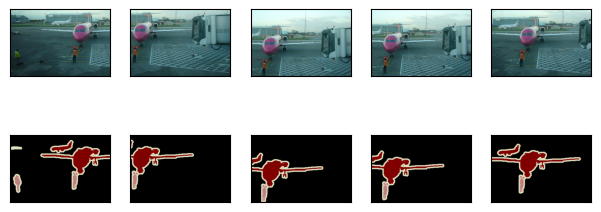

In [23]:
imgs = []
'''
对第一张图像及其标签进行n次随机裁剪，此处n=5。
注意此处是将每张特征数据图像及其对应掩码图像交叉保存的。
'''
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### 13.9.2.2 自定义语义分割数据集类
- 我们通过继承高级API提供的`Dataset`类，自定义了一个语义分割数据集类`VOCSegDataset`。
- 通过实现`__getitem__`函数，我们可以任意访问数据集中索引为`idx`的输入图像及其**每个像素的类别索引**。
- 由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本可以通过自定义的`filter`函数移除掉。
- 此外，我们还定义了`normalize_image`函数，从而对输入图像的RGB三个通道的值分别做标准化。


In [24]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

- VOCSegDataset详细注释版

In [25]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        # 对像素值进行规范化的参数，按照通道进行规范化
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # 裁剪尺寸
        self.crop_size = crop_size
        # 读取数据集，分为特征数据和标签
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        # 读取特征图像数据，并对特征数据进行过滤和规范化
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        # 对标签数据进行过滤
        self.labels = self.filter(labels)
        # 获取像素RGB值与标签映射
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
        
    # 将图像像素值除以255
    def normalize_image(self, img):
        return self.transform(img.float() / 255)
        
    # 通过图像的高度和宽度进行过滤，大于等于剪裁尺寸的图片保留下来，否则抛弃
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]
    
    # 索引功能重载，返回特征数据以及标签-类别索引之间的映射
    def __getitem__(self, idx):
        # 对图像进行随机裁剪
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### 13.9.2.3 读取数据集
- 我们通过自定义的`VOCSegDataset`类来分别创建训练集和测试集的实例。
- 假设我们指定随机裁剪的输出图像的形状为$320\times 480$，
- 下面我们可以查看训练集和测试集所保留的样本个数。


In [26]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [16]:
# 过滤后只有1114条数据，train_features共有1464条，过滤掉350条
l = 0
for i  in train_features:
    if i.shape[1]>=crop_size[0] and i.shape[2]>=crop_size[1]:
        l+=1
l

1114

- 设批量大小为64，我们定义训练集的迭代器。
- 打印第一个小批量的形状会发现：与图像分类或目标检测不同，这里的标签是一个三维数组。
  - 标签增加一个批量维，后两维是图像的高和宽。


In [17]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### 13.9.2.4 整合所有组件
- 最后定义以下`load_data_voc`函数来下载并读取Pascal VOC2012语义分割数据集。
- 它返回训练集和测试集的数据迭代器。


In [18]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [19]:
# 测试load_data_voc
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [22]:
# 一个批量的VOC数据集，注意特征数据和标签的形状
list(train_iter)[0][0].shape,list(train_iter)[0][1].shape

(torch.Size([64, 3, 320, 480]), torch.Size([64, 320, 480]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


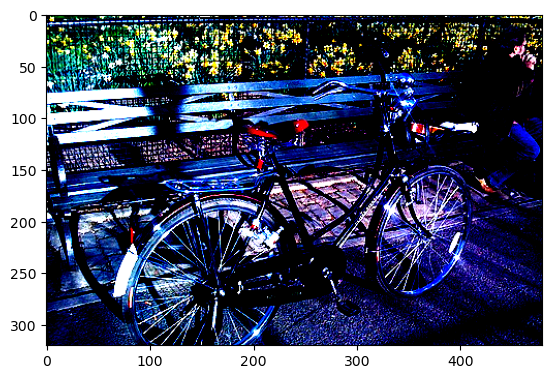

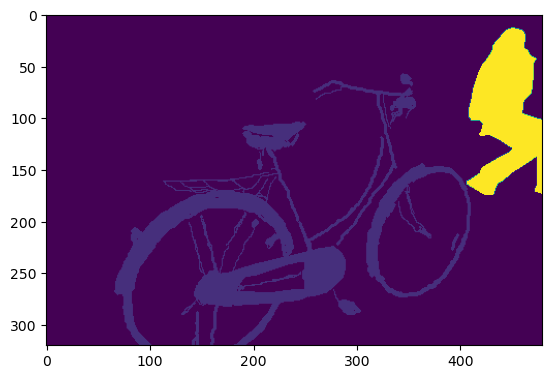

In [34]:
# 一个样本的特征数据和标签
d = list(train_iter)[0]
image = d[0][0].permute(1,2,0)
label = d[1][0]
plt.imshow(image)
plt.show()
plt.imshow(label)
plt.show()

In [35]:
# 标签的类型索引
label.unique()

tensor([ 0,  2, 15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


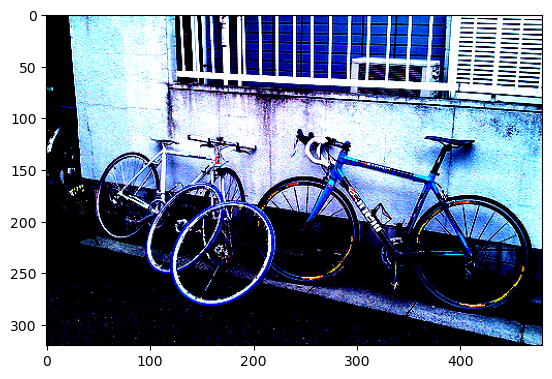

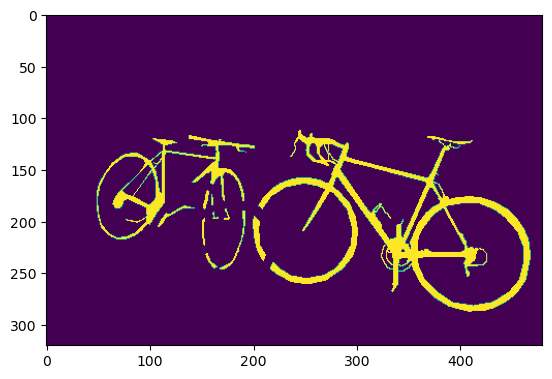

classe index:  tensor([0, 2])


In [48]:
# 通过批量迭代提取数据
for image, label in train_iter:
    plt.imshow(image[0].permute(1,2,0))
    plt.show()
    plt.imshow(label[0])
    plt.show()
    print('classe index: ', label[0].unique())
    break

## 小结

* 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容。
* 语义分割的一个重要的数据集叫做Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放。

-----
- **说明：RGB颜色值到类别索引的映射机制**
  - 在语义分割任务中，RGB图像的每个像素通过其三个通道（R, G, B）的颜色值表示特定的类别。
  - 为了高效地将这些颜色值映射到类别索引，需要**将三维的RGB值转换为一个唯一的一维整数索引**。
  - **索引计算的作用**
    - **目标**：将每个像素的RGB值（三维）转换为唯一的整数索引（一维），以便快速查找对应的类别。
    - **公式**：
      $$
      \text{Index} = (R \times 256 + G) \times 256 + B
      $$
  - **计算原理**
    - **唯一性保证**：
      - RGB每个通道的取值范围是0-255（8位），通过线性组合确保不同RGB值映射到不同的索引。
      - **数学推导**：
        $$
         \text{Index} = R \times 256^2 + G \times 256 + B
        $$
        由于每个分量独立且不重叠，任何两个不同的RGB组合生成的索引必然不同。
    - **示例验证**：
      - **RGB值 (128, 0, 0)**：
        $$
         \text{Index} = (128 \times 256 + 0) \times 256 + 0 = 8,388,608
        $$
      - **RGB值 (0, 128, 0)**：
        $$
         \text{Index} = (0 \times 256 + 128) \times 256 + 0 = 32,768
        $$
      - **RGB值 (0, 0, 128)**：
        $$
        \text{Index} = 128
        $$
      - 不同颜色生成的索引唯一，避免类别混淆。



  - **实际应用步骤**
    - **构建映射表**：
      - 初始化一个长度为 $256^3 = 16,777,216$ 的数组 `colormap2label`，初始值设为0。
      - 遍历预定义的 `VOC_COLORMAP`（每个类别对应的RGB颜色），为每个颜色计算索引并填充映射表：

    ```python
     for i, colormap in enumerate(VOC_COLORMAP):
         index = (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]
         colormap2label[index] = i  # i为类别索引
     ```

    - **转换标签图像**：
      - 输入：RGB格式的标签图像（形状为 `[3, H, W]`）。
      - 调整维度为 `[H, W, 3]`，转换为NumPy数组。
      - 对每个像素计算索引：

     ```python
     idx = (R * 256 + G) * 256 + B  # 逐像素计算
     ```
      - 使用 `colormap2label` 映射到类别索引，得到形状为 `[H, W]` 的索引图像。

  - **为何选择此方法？**
    - **高效性**：
      - 数组索引访问的时间复杂度为 $O(1)$，远快于字典查找。
      - 适合GPU加速，提升深度学习模型训练效率。
    - **内存紧凑**：
      - 使用预分配的固定长度数组，内存占用可控（约67MB，若用32位整数）。
    - **兼容性**：
      - 直接与PyTorch张量操作兼容，无需额外数据转换。

----